In [1]:
import json
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict

In [2]:
sys.path.insert(0, '../src/lib')

In [3]:
from utils import car_models
from utils.geometry import create_camera_matrix, euler_angles_to_rotation_matrix, euler_angles_to_quaternions, proj_point
from utils.ddd_utils import compute_box_3d, project_to_image
from utils.image import affine_transform, get_affine_transform, draw_msra_gaussian, draw_umich_gaussian, gaussian_radius, pad_img_sides
from utils.kaggle_cars_utils import parse_annot_str

In [4]:
INPUT_PATH = '../data/pku-autonomous-driving'
MODEL_DIR = os.path.join(INPUT_PATH, 'car_models_json')

In [5]:
def rand_affine(c, s, cf=0.1, sf=0.4):
    s = s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)
    c[0] += img.shape[1] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    c[1] += img.shape[0] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    return c, s


def stringify(p):
    return ', '.join(p.astype(str).tolist())

In [52]:
def read_split_file(split, data_dir=INPUT_PATH):
    path = os.path.join(data_dir, 'split', split+'.txt')
    with open(path) as f:
        return [line.rstrip('\n')[:-4] for line in f]
    
    
def load_car_models(model_dir=MODEL_DIR):
    """Load all the car models
    """
    car_models_all = OrderedDict([])
    print('loading %d car models' % len(car_models.models))
    for model in car_models.models:
        car_model = '%s/%s.json' % (model_dir, model.name)
        with open(car_model) as json_file:
            car = json.load(json_file)
        for key in ['vertices', 'faces']:
            car[key] = np.array(car[key])
        # fix the inconsistency between obj and pkl
        car['vertices'][:, [0, 1]] *= -1
        car_models_all[model.name] = car 
    return car_models_all  
    

def imread(path, img_dir=INPUT_PATH, bottom=False):
    path = os.path.join(img_dir, path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if bottom:
        h_mid = image.shape[0] // 2
        image = image[h_mid:]
    return image


def imshow(img, boxes=None, figsize=(16,8)):
    plt.figure(figsize=figsize)
    ax = plt.axes()
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())


def add_blend_img(back, fore, trans=0.7, white_theme=False):
    if white_theme:
        fore = 255 - fore
    if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
        fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
    if len(fore.shape) == 2:
        fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
    out = (back * (1. - trans) + fore * trans)
    out[out > 255] = 255
    out[out < 0] = 0
    return out.astype(np.uint8).copy()

In [7]:
def proj_points(pts_3d, rot_euler, translation, calib):
    # project 3D points to 2d image plane
    rot_mat = euler_angles_to_rotation_matrix(rot_euler).T
    rvect, _ = cv2.Rodrigues(rot_mat)
    imgpts, jac = cv2.projectPoints(
        np.float32(pts_3d), rvect, translation, calib[:,:3],
        distCoeffs=None)
    imgpts = np.int32(imgpts).reshape(-1, 2)
    return imgpts


def calc_bbox(pts_2d):
    x1, y1, x2, y2 = (pts_2d[:, 0].min(), pts_2d[:, 1].min(),
                      pts_2d[:, 0].max(), pts_2d[:, 1].max())
    return np.array([x1, y1, x2, y2])


def draw_segment(mask, pts_2d, faces):
    for face in faces - 1:
        pts = np.array([[pts_2d[idx, 0], pts_2d[idx, 1]] for idx in face], np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.drawContours(mask, [pts], 0, (255, 255, 255), -1)

In [8]:
def load_annotations(df, img_ids):
    anns = []
    models_3D = load_car_models()
    calib = create_camera_matrix()
    anns = [gen_img_annotation(img_id, df, models_3D, calib) 
            for img_id in img_ids]
    return anns


def gen_img_annotation(img_id, df, models_3D, calib):
    cond = df['ImageId'] == img_id
    cars = df.loc[cond, 'PredictionString'].values[0]
    cars = parse_annot_str(str(cars))
    for car in cars:
        car_name = car_models.car_id2name[car['car_id']].name
        car_model = models_3D[car_name]
        pts_2d = proj_points(
            car_model['vertices'], car['rotation'], car['location'], 
            calib)
        car['bbox'] = calc_bbox(pts_2d)
        car['pts'] = pts_2d #.astype(np.int16)
    return cars

In [9]:
# 2x3 x 3x1000 -> 2x1000
def affine_transform_pts(pts, t):
    new_pt = np.vstack([pts.T, np.ones(pts.shape[0])])
    new_pt = t @ new_pt
    return new_pt.T

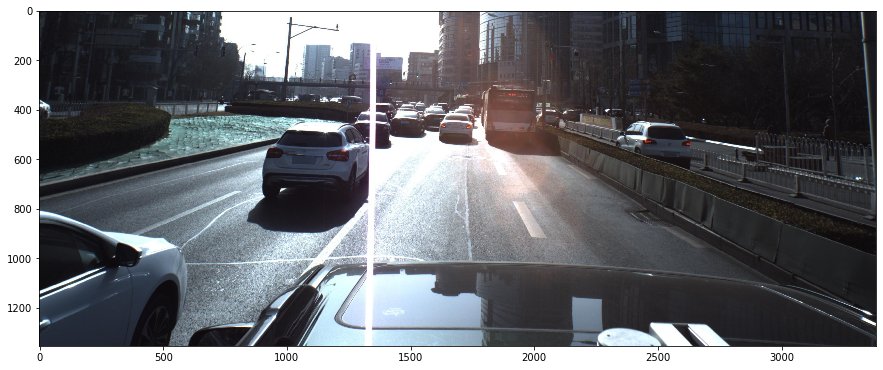

In [10]:
img_id = 'ID_0289b0bc8'
img_bottom_half = True
img = imread(f'train_images/{img_id}.jpg', bottom=img_bottom_half)
imshow(img)

In [11]:
height, width = img.shape[0], img.shape[1]

inp_w, inp_h = 1280, 512
down_ratio = 4
pad_w_pct = 0.3

out_w, out_h = inp_w // down_ratio, inp_h // down_ratio
out_w, out_h

c = np.array([width / 2., height / 2.])
s = np.array([width, height], dtype=np.int32)

num_classes = 1
max_objs = 50
calib = create_camera_matrix()

(width, height), (inp_w, inp_h), (out_w, out_h)

((3384, 1355), (1280, 512), (320, 128))

In [12]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
img_ids = read_split_file('train')
len(img_ids)

3800

In [13]:
%%time
train_anns = load_annotations(df, img_ids)
models_3D = load_car_models()

loading 79 car models
loading 79 car models
CPU times: user 30.7 s, sys: 247 ms, total: 31 s
Wall time: 31.1 s


In [16]:
locs = []
for img in train_anns:
    for car in img:
        locs.append(car['location'])
locs = np.vstack(locs)

MEAN, STD, MAX = [], [], []
for d, ax in zip([0, 1, 2], ['x', 'y', 'z']):
    locs_ax = locs[:,d]
    print('[%s] min: %.02f, max: %.02f' % (ax, locs_ax.min(), locs_ax.max()))
    MEAN.append(locs_ax.mean())
    STD.append(locs_ax.std())
    MAX.append(locs_ax.max())

[x] min: -82.85, max: 519.83
[y] min: 1.02, max: 689.12
[z] min: 3.07, max: 3502.94


In [17]:
MEAN, STD, MAX

([-3.5629601751602578, 9.651555247009528, 52.16890483453853],
 [14.60053757060545, 6.975729856024424, 40.72864069295426],
 [519.834, 689.119, 3502.94])

In [18]:
count = 0

ID_005bf2575


(-0.01731322, 0.032702748)

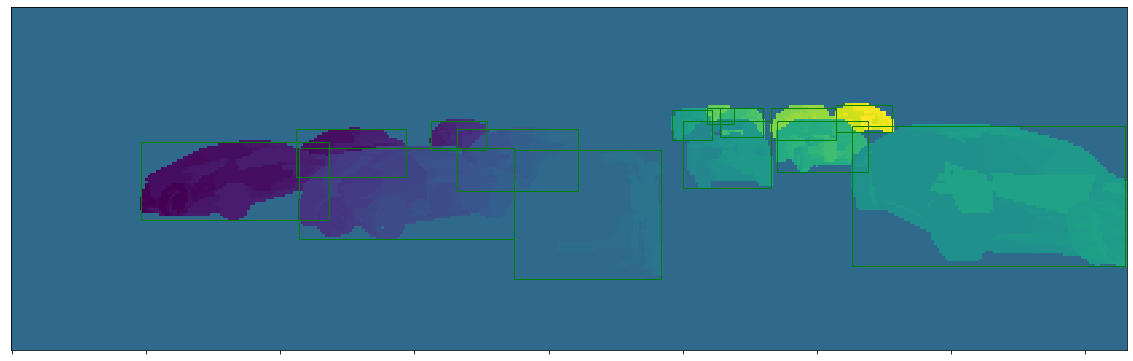

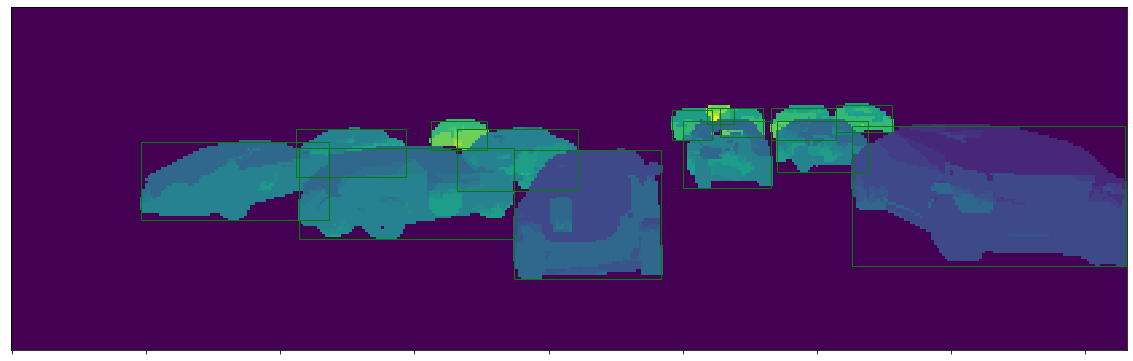

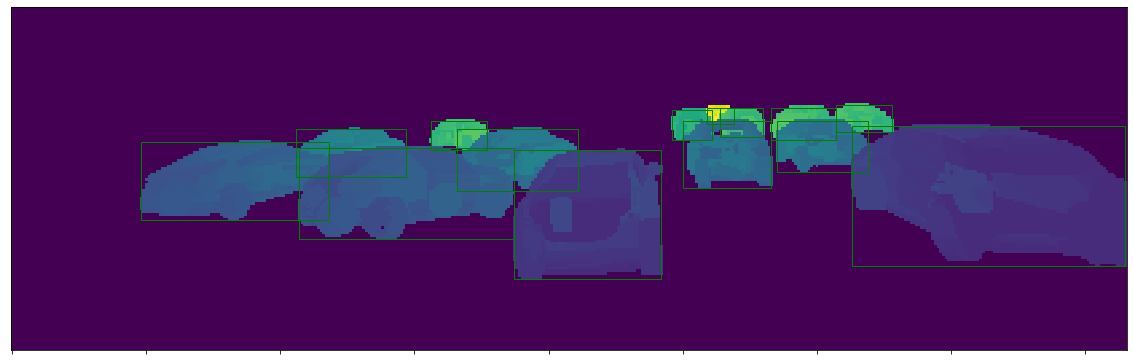

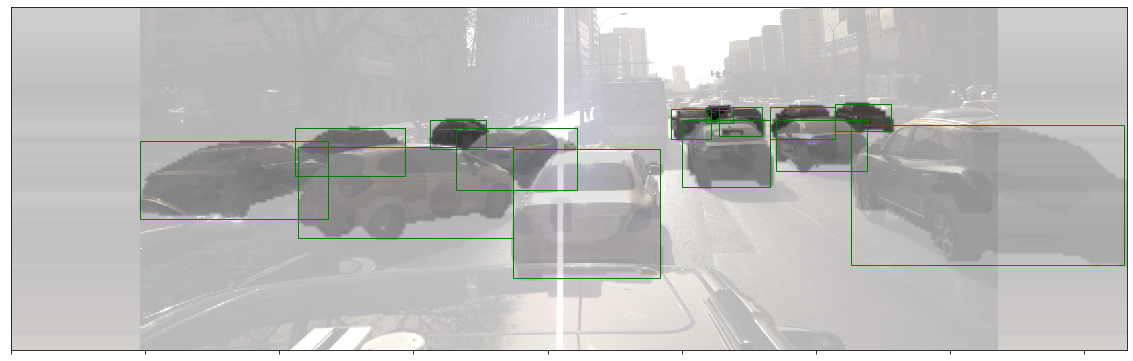

In [58]:
draw_gaussian = draw_umich_gaussian
aug = False
flipped = True
stop_counter = True

if not stop_counter:
    img_id = img_ids[count]
    img_anns = train_anns[count]
    img_anns.sort(key=lambda x: x['location'][2], reverse=True)

xy_off = np.array([0, 0])
img_path = os.path.join(INPUT_PATH, 'train_images', img_id+'.jpg')
img = cv2.imread(img_path)
if img_bottom_half:
    half_h = img.shape[0] // 2
    img = img[half_h:]
    xy_off[1] -= half_h

c = np.array([width / 2., height / 2.])
s = np.array([width, height], dtype=np.int32)

if flipped:
    img = img[:, ::-1, :]
    c[0] =  width - c[0] - 1

trans_input = get_affine_transform(c, s, 0, [inp_w, inp_h])
trans_output = get_affine_transform(c, s, 0, [out_w, out_h])

inp = cv2.warpAffine(img, trans_input, (inp_w, inp_h), flags=cv2.INTER_LINEAR)
inp = inp.transpose(2, 0, 1)
hm = np.zeros((num_classes, out_h, out_w), dtype=np.float32)
mask = np.zeros((3, out_h, out_w), dtype=np.float32)
reg = np.zeros((max_objs, 2), dtype=np.float32)

if pad_w_pct > 0:
    inp = pad_img_sides(inp, pad_w_pct)
    hm = pad_img_sides(hm, pad_w_pct)
    mask = pad_img_sides(mask, pad_w_pct)
    xy_off[0] += int(width * pad_w_pct / 2)
    
num_objs = min(len(img_anns), max_objs)
bboxes = []
for k in range(num_objs):
    ann = img_anns[k]
    ct = proj_point(ann['location'], calib)
    bbox = np.array(ann['bbox'])
    pts = np.array(ann['pts'])
    car_name = car_models.car_id2name[ann['car_id']].name
    car_model = models_3D[car_name]

    Rt = np.eye(4)
    Rt[:3, 3] = ann['location']
    Rt[:3,:3] = euler_angles_to_rotation_matrix(ann['rotation']).T

    vert = car_model['vertices']
    P = np.ones((vert.shape[0],vert.shape[1]+1))
    P[:, :-1] = vert

    pts_world = Rt[:3,:] @ P.T # 3 x vertices
    pts_3d = (calib[:,:3] @ pts_world).T
    pts_2d = pts_3d[:,:2] / pts_3d[:,2:]
    pts_world= pts_world.T
    
    if flipped:
        ct[0] = width-1 - ct[0]
        bbox[[0, 2]] = width-1 - bbox[[2, 0]]
        pts_2d[:,0] = width-1 - pts[:,0]
        pts_world[:,0] = -pts_world[:,0] # x_delta ?
       
    ct += xy_off
    bbox += np.hstack([xy_off, xy_off])
    pts_2d += xy_off

    ct = affine_transform(ct, trans_output)
    ct0 = np.copy(ct)
    ct[0] = np.clip(ct[0], 0, hm.shape[2] - 1)
    ct[1] = np.clip(ct[1], 0, hm.shape[1] - 1)
    ct_int = ct.astype(np.int32)
    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, hm.shape[2] - 1)
    bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, hm.shape[1] - 1)
    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    pad_px = (hm.shape[2] - out_w) // 2
    
    if h > 0 and w > 0 and bbox[2] > pad_px and bbox[0] < hm.shape[2] - pad_px:
        radius = gaussian_radius((h, w))
        radius = max(0, int(radius))
        draw_gaussian(hm[0], ct, radius)
        bboxes.append(bbox)
        
        pts_2d = affine_transform_pts(pts_2d, trans_output)        
        for face in car_model['faces'] - 1:
            pts_face_2d = np.int32(pts_2d[face]).reshape((-1, 1, 2))
            pts_face_3d = np.int32(pts_world[face])
            for dim in range(3):
                v = pts_face_3d[:,dim].mean() / MAX[dim]
                cv2.drawContours(mask[dim], [pts_face_2d], 0, v, -1)
        
        reg[k] = ct0 - ct_int

if not stop_counter:
    count += 1

print(img_id)
figsize = (20, 10)
    
for i in range(3):
    imshow(mask[i], boxes=bboxes, figsize=figsize)

inp0 = inp.transpose(1, 2, 0)
bboxes0 = [bb * down_ratio for bb in bboxes]
mask0 = mask[2] / mask[2].max() * 255
blend = add_blend_img(inp0, mask0, white_theme=True)
imshow(blend, boxes=bboxes0, figsize=figsize)

mask.min(), mask.max()

In [45]:
def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords


def unproject_2d_to_3d(pt_2d, depth, P):
    # pts_2d: 2
    # depth: 1
    # P: 3 x 4
    # return: 3
    z = depth - P[2, 3]
    x = (pt_2d[0] * depth - P[0, 3] - P[0, 2] * z) / P[0, 0]
    y = (pt_2d[1] * depth - P[1, 3] - P[1, 2] * z) / P[1, 1]
    pt_3d = np.array([x, y, z], dtype=np.float32)
    return pt_3d

In [50]:
ann['location']

array([-5.45155,  2.39099,  8.22236])

In [51]:
ct_r = transform_preds(ct0[None,:], c, s, (out_w, out_h))
ct_r = ct_r[0]
print(ct_r)
ct_r -= [x_off, y_off]
print(ct_r)
unproject_2d_to_3d(ct_r, ann['location'][-1], calib)

[3731.71230316  670.51324034]
[3224.71230316 2025.51324034]


array([5.4890985, 2.39099  , 8.22236  ], dtype=float32)